In [ ]:
""" 
Segment the image based on the score distribution


"""

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os

# Get the path to the parent folder of the notebook
notebook_dir = os.getcwd()  # should be 'project/notebooks'
utils_path = os.path.abspath(os.path.join(notebook_dir, '..', 'utilis'))

# Add to sys.path
if utils_path not in sys.path:
    sys.path.append(utils_path)

import matplotlib as mpl
import json
with open(notebook_dir + '/' + 'config.json', 'r') as f:
    loaded_settings = json.load(f)
print(loaded_settings.keys())

import matplotlib.pyplot as plt
plt.rcParams.update(loaded_settings['plot_config'])

dict_keys(['dx', 'dy', 'plot_config'])


In [16]:
########## input ###############
selected_amp = 13
data_type = 's'
sample_se = '2'
#################################

In [ ]:
import pickle
save_folder_0 = f'{notebook_dir}/results_folder/'

##### load the similarity score results #####

# save_folder = '20250908_OVPE_2021_' + data_type
# save_folder = '20250905_HVPE_2021_' + data_type
save_folder = f'20251002_ffc_2024_{data_type}_{sample_se}' 
save_path = save_folder_0 + save_folder
similarity_score_data_save_target = save_path + "/similarity_score.pickle"

with open(similarity_score_data_save_target, 'rb') as f:
    ss_data = pickle.load(f)

########################################################


##### load the coordinate info #####

from part1_data_lodaer import *
## for the case of ovpe_2021 ##
# _, S = data_loader_ovpe_2021_optimized(results_type='S', data_type = data_type)
# map_shape = [18, 69]
# x_coords = S[:, 0].reshape(shape)
# y_coords = S[:, 1].reshape(shape)

## for the case of ffc_2024
_, S = data_loader_ffc_2024_optimized(results_type='S', data_type=data_type, sample_se = sample_se)
map_shape = (61, 25)

###########################################################

X and S have shapes of (0,), (1525, 2)
Memory usage: X=0.0MB, S=0.0MB


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.morphology import erosion, disk

def process_image_segmentation_w2(
    data_to_analyze, shape=(61, 25),
    rotate_angle = None,
    kernel_noise_size=(2, 2),
    kernel_sure_bg_size_close=(5, 5),
    kernel_sure_bg_size_dilate=(3, 3),
    threshold_binary='otsu',
    if_invert_flag=True,
    plot_raw=True,
    show_plots=True,
    noise_inters=2,
    fg_threshold=0.35,
    marker_method='connected_components', # 'connected_components' or 'peak_local_max' or 'erosion'
    peak_min_distance=5,                  # Only for peak_local_max
    erosion_radius=3,                     # Only for erosion
    S=None,
    # boundary_color='',
):
    
    # some external controls for the visualization
    text_x = -0.32

    # prepare the coordinate info
    extent = None
    if S is not None:
        x_coords = S[:, 0].reshape(shape)
        y_coords = S[:, 1].reshape(shape)
        extent = [x_coords.min(), x_coords.max(),
                  y_coords.min(), y_coords.max()]

    # Step 1: Normalize and prepare image
    image = data_to_analyze.reshape(shape)
    if rotate_angle:
        image = image.T
    img_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img_uint8 = img_norm.astype(np.uint8)
    img_inverted = 255 - img_uint8 if if_invert_flag else img_uint8

    if plot_raw:
        plt.figure(figsize=(4, 8))
        plt.subplot(1, 1, 1)
        plt.imshow(img_inverted, cmap='grey', extent=extent)
        plt.title('Raw Image')
        plt.colorbar()

    # Step 2: Binarize
    if isinstance(threshold_binary, str) and threshold_binary == 'otsu':
        _, binary = cv2.threshold(img_inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        thresh_val = threshold_binary
        _, binary = cv2.threshold(img_inverted, thresh_val, 255, cv2.THRESH_BINARY)

    if show_plots:
        plt.figure(figsize=(11, 20), dpi = 300)
        plt.subplot(3, 3, 1)
        ax = plt.gca()
        ax.text(text_x, 1.02, f'(a)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(binary, cmap='jet', extent=extent)
        plt.title('Binary Image')
        plt.colorbar()

    # Step 3: Remove noise with opening
    kernel = np.ones(kernel_noise_size, np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=noise_inters)
    if show_plots:
        plt.subplot(3, 3, 2)
        ax = plt.gca()
        ax.text(text_x, 1.02, f'(b)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(opening, cmap='jet', extent=extent)
        plt.title('Noise Removed')
        plt.colorbar()

    # Step 4: use opening to modulate the raw image
    modulated_img = img_inverted.copy()
    modulated_img[opening == 0] = 0 
    if show_plots:
        plt.subplot(3, 3, 3)
        ax = plt.gca()
        ax.text(-0.42, 1.02, f'(c)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(modulated_img, cmap='jet', extent=extent)
        plt.title(f'Modulated raw image')
        plt.colorbar()

    # Step 5: Get sure foreground 
    _, sure_fg = cv2.threshold(modulated_img, fg_threshold * modulated_img.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    # from skimage.segmentation import clear_border
    # sure_fg = clear_border(sure_fg) #Remove edge touching grains
    if show_plots:
        plt.subplot(3, 3, 4)
        ax = plt.gca()
        ax.text(text_x, 1.02, f'(d)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(sure_fg, cmap='jet', extent=extent)
        plt.title(f'Sure Foreground')
        plt.colorbar()

    # Step 7: Get sure background by Morphological closing and dilate
    kernel_sure_bg_close = np.ones(kernel_sure_bg_size_close, np.uint8)
    sure_bg_closed = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_sure_bg_close)

    kernel_dilate = np.ones(kernel_sure_bg_size_dilate, np.uint8)
    sure_bg = cv2.dilate(sure_bg_closed, kernel_dilate, iterations=1)

    if show_plots:
        plt.subplot(3, 3, 5)
        ax = plt.gca()
        ax.text(text_x, 1.02, f'(e)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(sure_bg, cmap='jet', extent=extent)
        plt.title('Sure Background')
        plt.colorbar()

    # Step 8: Unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)
    if show_plots:
        plt.subplot(3, 3, 6)
        ax = plt.gca()
        ax.text(text_x, 1.02, f'(f)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(unknown, cmap='jet', extent=extent)
        plt.title('Unknown Region')
        plt.colorbar()

    # ==== NEW: Marker generation methods ====
    if marker_method == 'connected_components':
        # Standard method
        _, markers = cv2.connectedComponents(sure_fg)
        marker_desc = 'Connected Components'
    elif marker_method == 'peak_local_max':
        # Use regional maxima as seeds
        coordinates = peak_local_max(
            sure_fg,
            min_distance=peak_min_distance,
            labels=sure_fg,  # restrict to sure_fg area
            exclude_border=False
        )
        markers = np.zeros_like(sure_fg, dtype=np.int32)
        for i, (y, x) in enumerate(coordinates, 1):
            markers[y, x] = i
        marker_desc = f'Peak Local Max (min_distance={peak_min_distance})'
    elif marker_method == 'erosion':
        # Erode sure_fg to get marker "cores"
        # Use disk structuring element (from skimage) for smoothness
        sure_fg_bool = (sure_fg > 0)
        core = erosion(sure_fg_bool, disk(erosion_radius))
        # Label the eroded blobs
        _, markers = cv2.connectedComponents(core.astype(np.uint8))
        marker_desc = f'Erosion (radius={erosion_radius})'
    else:
        raise ValueError(f"Unknown marker_method: {marker_method}")

    # Ensure markers in unknown region are 0 (for watershed)
    markers = markers + 1
    markers[unknown == 255] = 0
    if show_plots:
        plt.subplot(3, 3, 7)
        ax = plt.gca()
        ax.text(text_x, 1.02, f'(g)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(markers, cmap='jet', extent=extent)
        plt.title(f'Final Markers')
        plt.colorbar()

    # Step 10: Watershed
    img_color = cv2.cvtColor(img_inverted, cv2.COLOR_GRAY2BGR)
    markers_ws = cv2.watershed(img_color, markers.copy())  # copy to avoid in-place change

    if show_plots:
        plt.subplot(3, 3, 8)
        ax = plt.gca()
        ax.text(-0.37, 1.02, f'(h)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(markers_ws, cmap='jet', extent=extent)
        plt.title('Watershed Result')
        plt.colorbar()


 # === Overlay boundary on raw/preprocessed image ===
   #  boundary_overlay = None
    img_rgb = cv2.cvtColor(img_inverted, cv2.COLOR_GRAY2RGB)
    img_rgb[markers_ws == -1] = [0,255,255]  
    if show_plots:
        plt.subplot(3, 3, 9)
        ax = plt.gca()
        ax.text(text_x, 1.02, f'(i)', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        plt.imshow(img_rgb, cmap='grey',extent=extent)
        plt.tight_layout()
        plt.colorbar()
        plt.show()
        

    # Return all results
    return {
        'binary': binary,
        'img_inverted': img_inverted,
        'opening': opening,
        'sure_bg': sure_bg,
        'sure_fg': sure_fg,
        'unknown': unknown,
        'markers': markers_ws,
        'marker_method_used': marker_desc,
        # 'boundary_overlay': boundary_overlay
    }


In [19]:
# again, analysis with the results from similarity scores
data_to_analyze = np.array(ss_data[selected_amp]['jaccard_scores'])

In [20]:
## for the case of ovpe_2021

# results_to_analyze = process_image_segmentation_w2(
#     S = S, shape = map_shape,
#     rotate_angle = True,
#     threshold_binary = 'otsu',
#     data_to_analyze = data_to_analyze,
#     if_invert_flag = True,
#     plot_raw = False,
#     fg_threshold = 0,
#     noise_inters=1,   
#     kernel_noise_size=(1, 2),
#     kernel_sure_bg_size_close = (1, 1),
#     kernel_sure_bg_size_dilate = (3, 3),
#     marker_method='connected_components'
# )

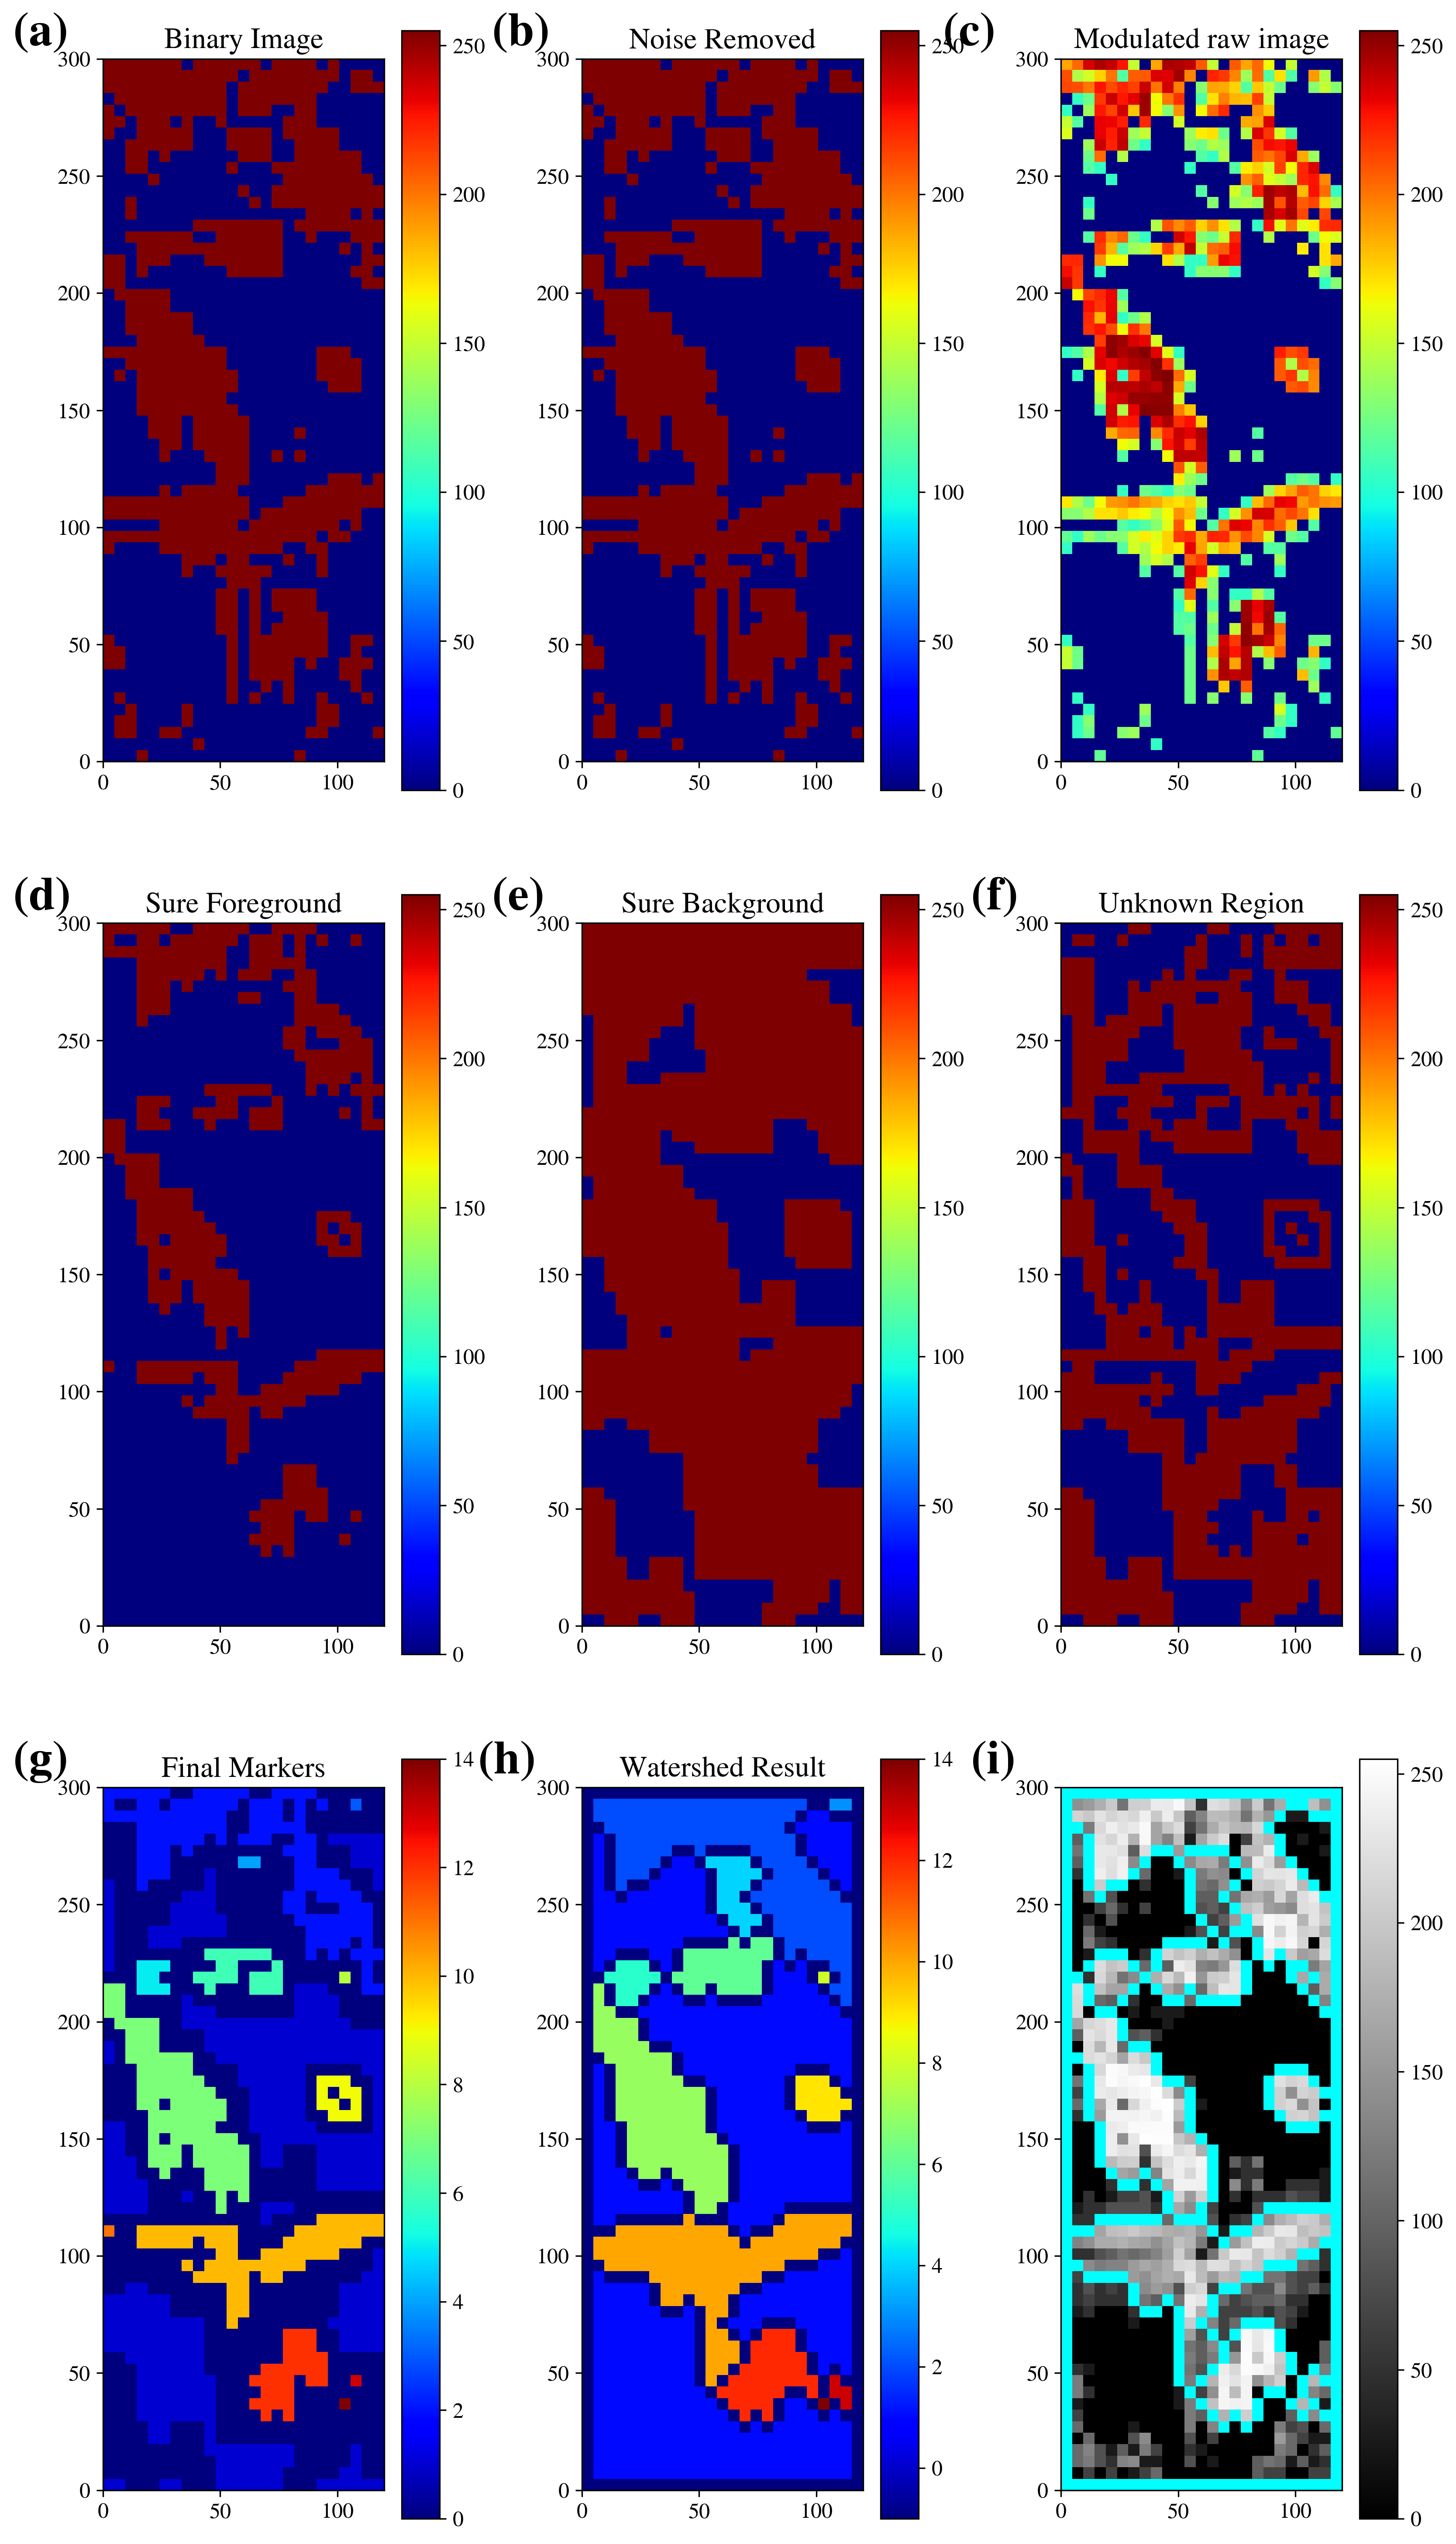

'  \nFor as\n\n'

In [21]:
## for the case of ffc_2024
"""  
For S

"""

results_to_analyze = process_image_segmentation_w2(
    S = S,
    threshold_binary = 'otsu',
    data_to_analyze = data_to_analyze,
    if_invert_flag = True,
    plot_raw = False,
    show_plots = True,
    fg_threshold = 0.63,
    noise_inters=1,   
    kernel_noise_size=(1, 1),
    kernel_sure_bg_size_close = (1, 1),
    kernel_sure_bg_size_dilate = (3, 3),
    marker_method='connected_components'

)


"""  
For as

"""

# results_to_analyze = process_image_segmentation_w2(
#     S = S,
#     threshold_binary = 'otsu',
#     data_to_analyze = data_to_analyze,
#     if_invert_flag = True,
#     plot_raw = False,
#     show_plots = True,
#     fg_threshold = 0.57,
#     noise_inters=1,   
#     kernel_noise_size=(1, 1),
#     kernel_sure_bg_size_close = (3, 3),
#     kernel_sure_bg_size_dilate = (3, 3),
#     marker_method='connected_components'

# )

In [22]:
# save the image_segmentation results
is_save_name = "region_detection.pickle"
is_save_target = save_path + '/' + is_save_name
with open(is_save_target, 'wb') as f:
    pickle.dump(results_to_analyze, f)

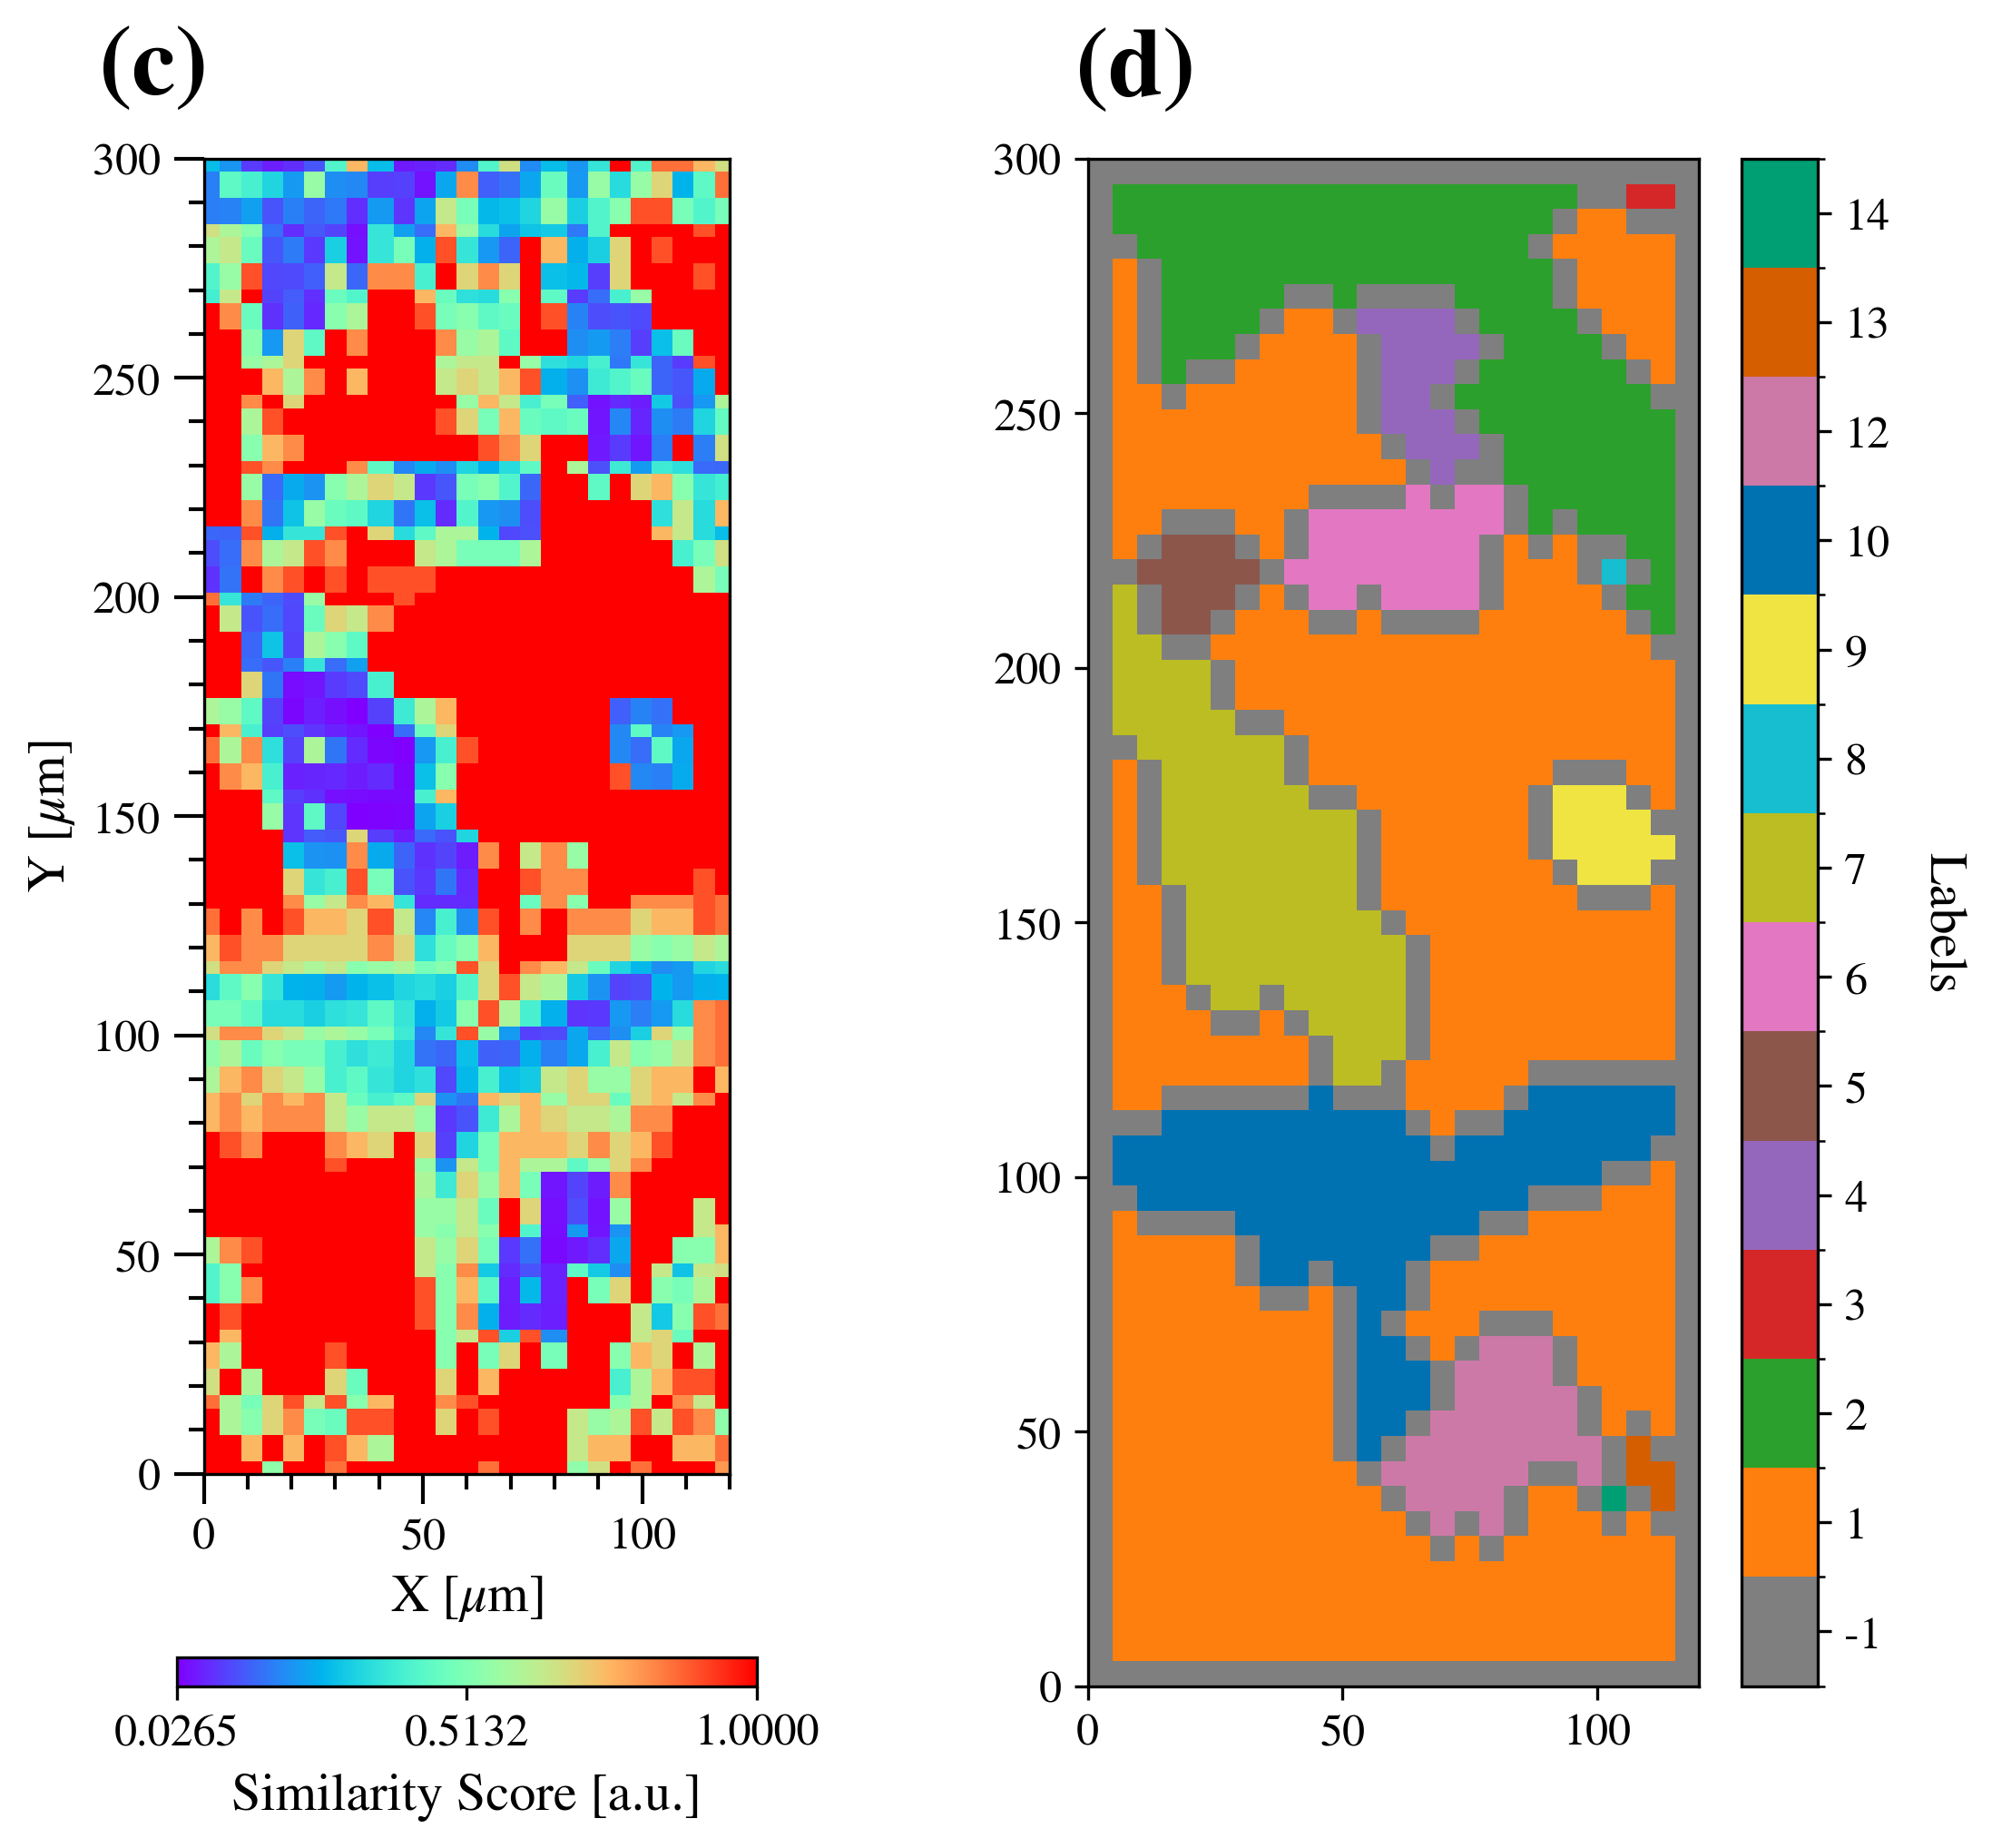

In [23]:
# for the visualization in the paper
from utilis_plot import create_label_color_mapping
GLOBAL_LABEL_COLORS = create_label_color_mapping(max_labels=20)

import utilis_plot
from utilis_plot import sample_plot, create_label_heatmap

fig, axes = plt.subplots(1, 2, figsize = (7.5, 7), dpi = 300)

# selected_amp = 5

sample_plot(axes[0], S = S, data = ss_data[13.0]['jaccard_scores'],
           colorbar_title = 'Similarity Score [a.u.]', label = 'c'
           , set_ticks_flag = True
           )

create_label_heatmap(ax = axes[1], S = S
                     , markers = results_to_analyze['markers']
                     , label_to_color=GLOBAL_LABEL_COLORS
                     ,  label = 'd'
                     , set_ticks_flag = True
                     )
